In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

## Read datasets

In [3]:
# Read the usdm dataset
usdm = pd.read_csv('./ByCounty_clean.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])
# Check the len of FIPS STR 
usdm['FIPS STR']=usdm.apply(lambda x: '0'+ str(x['FIPS']) if len(str(x['FIPS']))!=5 else str(x['FIPS']), axis = 1)

five_dig_FIPS = np.sum([ len(County_FIPS) !=5  for County_FIPS in usdm['FIPS STR'].unique()])
print(f'There are now {five_dig_FIPS} county has the wrong FIPS  ')

There are now 0 county has the wrong FIPS  


In [4]:
# Read and preprocess the smap dataset
# Preprocess the date format of smap2
smap1 = pd.read_csv('./SMAP70.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])
smap1['MapDate']=[dt.datetime.strptime(dates,'%Y-%m-%d') for dates in smap1['Dates']]
smap1 = smap1.set_index('MapDate').drop(columns =['Dates','08043','08049','08051'])

# Preprocess the date formate of smap2
smap2 = pd.read_csv('./SMAP450.csv', parse_dates=True, low_memory=False)
smap2['MapDate']=[dt.datetime.strptime(dates,'%m/%d/%Y') for dates in smap2['Dates']]
smap2 = smap2.set_index('MapDate').drop(columns =['Dates'])
smap2.columns = np.array(['0'+ str(x) if len(str(x))!=5 else str(x) for x in smap2.columns])

# merge the two dataframe
smap = pd.concat([smap1, smap2], axis=1)
smap.to_csv('./SMAP_full.csv')

In [5]:
# Read the SET dataset
SET = pd.read_csv('SET_full.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])
SET['time'] = pd.to_datetime(SET['time']).dt.date

In [6]:
# Read and preprocess the NOAA dataset
NOAA = pd.read_csv('NOAA_daily.csv', parse_dates=True, low_memory=False).drop(columns = 'Unnamed: 0')
NOAA['MapDate']=[dt.datetime.strptime(dates,'%Y-%m-%d') for dates in NOAA['index']]
NOAA['MapDate'] = pd.to_datetime(NOAA['MapDate']).dt.date
NOAA = NOAA.sort_values(by=['MapDate']).reset_index().drop(columns = ['index'])
NOAA = NOAA[NOAA['MapDate'] <= datetime.date(2022,2,28)]

In [7]:
# Read the FIPS csv
fips = pd.read_csv('https://raw.githubusercontent.com/kjhealy/fips-codes/master/state_and_county_fips_master.csv')

In [8]:
# read NDRE and NDVI
NDRE = pd.read_csv('NDRE_change.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])
NDVI = pd.read_csv('NDVI_change.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])

In [22]:
# Construct the FIPS column
FIPS_list = []
for i in range(len(NDRE)):
    row = NDRE.iloc[i]
    state = str(row['STATEFP'])
    county = str(row['COUNTYFP'])
    if len(state) == 1:
        state = '0'+state
    if len(county) == 2:
        county = '0'+county
    elif len(county) == 1:
        county = '00'+county
    FIPS_list.append(state+county)
NDRE['FIPS'] = FIPS_list

In [23]:
FIPS_list = []
for i in range(len(NDVI)):
    row = NDVI.iloc[i]
    state = str(row['STATEFP'])
    county = str(row['COUNTYFP'])
    if len(state) == 1:
        state = '0'+state
    if len(county) == 2:
        county = '0'+county
    elif len(county) == 1:
        county = '00'+county
    FIPS_list.append(state+county)
NDVI['FIPS'] = FIPS_list

## Preprocess SET data to match date


In [9]:
# 用week 数据集将 SET 数据集中的每个日期替换为当周起始日期
# use weekdate.csv to replace the date in SET with start date in USDM
Week = pd.read_csv('weekdate.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])

Week['MapDate']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['MapDate']]
Week['ValidStart']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['ValidStart']]
Week['ValidEnd']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['ValidEnd']]

# 截取到2015年一月之前
# date has to be after 2014/12/15
Week = Week[Week['MapDate'].dt.date>= datetime.date(2014,12,25)].reset_index()

mask = [np.sum(day > Week['ValidEnd'].dt.date) for day in SET['time']]
SET['time']=np.array(Week['MapDate'].iloc[mask])
SET['time']=SET['time'].astype(str)

# 计算每周的平均值
# weekly average..
SET=SET.groupby('time').mean()
SET.head()

,1007_roff,1007_evap,1067_roff,1067_evap,1077_roff,1077_evap,1095_roff,1095_evap,1099_roff,1099_evap,...,56017_roff,56017_evap,56021_roff,56021_evap,56031_roff,56031_evap,56037_roff,56037_evap,56043_roff,56043_evap
time,,,,,,,,,,,,,,,,,,,,,
2014-12-30,0.001730,-0.000370,0.000018,-0.000108,0.000651,-0.000270,0.003249,-0.000288,0.000957,-0.000195,...,4.470348e-08,0.000024,8.642673e-08,0.000001,2.682209e-08,-0.000085,2.235174e-07,0.000019,4.798174e-07,0.000017
2015-01-06,0.000068,-0.000099,0.000016,-0.000124,0.000373,-0.000080,0.000132,-0.000467,0.000030,-0.000111,...,4.470348e-08,0.000027,1.336847e-06,-0.000156,8.419156e-07,-0.000193,2.235174e-07,0.000059,4.821590e-07,0.000016
2015-01-13,0.000077,-0.000135,0.000017,-0.000135,0.000429,-0.000134,0.000138,-0.000214,0.000037,-0.000163,...,4.470348e-08,0.000041,1.298530e-07,-0.000281,4.821590e-07,-0.000560,2.277749e-07,0.000022,4.842877e-07,0.000025
2015-01-20,0.000395,-0.000387,0.000618,-0.000327,0.000511,-0.000319,0.000777,-0.000392,0.001150,-0.000317,...,4.470348e-08,0.000046,4.065888e-07,-0.000100,1.660415e-07,-0.000070,2.245818e-07,0.000056,4.885452e-07,0.000024
2015-01-27,0.000193,-0.000216,0.000036,-0.000240,0.000670,-0.000250,0.000361,-0.000363,0.000035,-0.000243,...,6.907753e-07,0.000038,2.916370e-07,-0.000084,2.426761e-07,-0.000091,2.426761e-07,-0.000005,4.885452e-07,0.000023


## Merging the SET dataset

In [10]:
county_list = pd.read_csv('County_450.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])['county'].values

mask = usdm['FIPS'].apply(lambda x: x in county_list )

usdm_select=usdm[mask]

########
# SMAP part
########

"""
smap = smap.set_index('date')

usdm_select['smap'] = usdm_select.apply(lambda x: smap.loc[x['MapDate'],x['FIPS STR']],axis = 1)

"""
# code non-exist value or wrong value in -9999, similarly as in SMAP
usdm_select['roff'] = usdm_select.apply(lambda x: SET.loc[x['MapDate'],str(x['FIPS'])+'_roff'] 
                  if dt.datetime.strptime(x['MapDate'],'%Y-%m-%d').date()>= datetime.date(2014,12,30) and dt.datetime.strptime(x['MapDate'],'%Y-%m-%d').date() <= datetime.date(2021,12,28)
                  else -9999,axis = 1)

usdm_select['evap'] = usdm_select.apply(lambda x: SET.loc[x['MapDate'],str(x['FIPS'])+'_evap'] 
                  if dt.datetime.strptime(x['MapDate'],'%Y-%m-%d').date()>= datetime.date(2014,12,30) and dt.datetime.strptime(x['MapDate'],'%Y-%m-%d').date() <= datetime.date(2021,12,28)
                  else -9999,axis = 1)

##  Merging the smap dataset

In [11]:
usdm_select['smap'] = usdm_select.apply(lambda x: smap.loc[x['MapDate'],x['FIPS STR']].values[0] if dt.datetime.strptime(x['MapDate'],'%Y-%m-%d').date()>= datetime.date(2014,12,30) else -9999,axis = 1)

## Merging the NOAA dataset

In [12]:
# 用 week 数据集将 NOAA 数据集中的每个日期替换为当周起始日期
# use weekdate.csv to replace the date in SET with start date in NOAA dataset

Week = pd.read_csv('weekdate.csv', parse_dates=True, low_memory=False).drop(columns=['Unnamed: 0'])

Week['MapDate']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['MapDate']]
Week['ValidStart']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['ValidStart']]
Week['ValidEnd']=[dt.datetime.strptime(day,'%Y-%m-%d') for day in Week['ValidEnd']]

# 截取到2015年一月之前
# date has to be after 2014/12/15
Week = Week[Week['MapDate'].dt.date>= datetime.date(2011,12,27)].reset_index()

In [13]:
# 要run 20min
mask = [np.sum(day > Week['ValidEnd'].dt.date) for day in NOAA['MapDate']]

In [14]:
NOAA['time']=np.array(Week['MapDate'].iloc[mask])
NOAA['time']=NOAA['time'].astype(str)
NOAA_temp = NOAA
NOAA_temp.to_csv('./NOAA_temp.csv')

In [15]:
# Construct the double index NOAA_final
NOAA_temp['FIP'] = NOAA_temp['FIP'].astype('int')
NOAA_final = NOAA_temp.drop(columns = 'MapDate').groupby(['time','FIP']).mean()

In [16]:
# Insert the PRCP column
usdm_select['PRCP'] = usdm_select.apply(lambda x: NOAA_final.loc[x['MapDate'],x['FIPS']]['PRCP'] if x['FIPS'] in NOAA_final.loc[x['MapDate']].index else np.nan,axis = 1)


In [17]:
# Insert the SNWD column
usdm_select['SNWD'] = usdm_select.apply(lambda x: NOAA_final.loc[x['MapDate'],x['FIPS']]['SNWD'] if x['FIPS'] in NOAA_final.loc[x['MapDate']].index else np.nan,axis = 1)

In [18]:
# Insert the TMAX column
usdm_select['TMAX'] = usdm_select.apply(lambda x: NOAA_final.loc[x['MapDate'],x['FIPS']]['TMAX'] if x['FIPS'] in NOAA_final.loc[x['MapDate']].index else np.nan,axis = 1)

In [19]:
# Insert the TMIN column
usdm_select['TMIN'] = usdm_select.apply(lambda x: NOAA_final.loc[x['MapDate'],x['FIPS']]['TMIN'] if x['FIPS'] in NOAA_final.loc[x['MapDate']].index else np.nan,axis = 1)

In [21]:
NDRE

,NAME,STATEFP,COUNTYFP,Start,End,NDRE_1,NDRE_2,NDRE_diff
0,Cuming,31,39,2017-01-03,2017-01-09,42.897309,45.141506,-4.971471
1,Cuming,31,39,2017-01-10,2017-01-16,45.141506,45.440663,-0.658347
2,Cuming,31,39,2017-01-17,2017-01-23,45.440663,62.759001,-27.594986
3,Cuming,31,39,2017-01-24,2017-01-30,62.759001,80.152308,-21.700320
4,Cuming,31,39,2017-01-31,2017-02-06,80.152308,89.256180,-10.199710
...,...,...,...,...,...,...,...,...
869672,Wayne,54,99,2022-01-25,2022-01-31,37.866828,30.465186,24.295411
869673,Wayne,54,99,2022-02-01,2022-02-07,30.465186,38.300727,-20.457944
869674,Wayne,54,99,2022-02-08,2022-02-14,38.300727,53.891316,-28.929686
869675,Wayne,54,99,2022-02-15,2022-02-21,53.891316,60.214339,-10.500860


### Merging NDVI

In [24]:
NDRE_g = NDRE.groupby(['Start','FIPS']).mean()
NDVI_g = NDVI.groupby(['Start','FIPS']).mean()

In [25]:
NDVI_1 = []
NDVI_2 = []
NDVI_diff =[]

NDVI_g_index = NDVI_g.index
for i in range(len(usdm_select)):
    row =usdm_select.iloc[i]
    Start = row['ValidStart']
    Fips = row['FIPS STR']
    
    if Start in NDVI_g_index and Fips in NDVI_g.loc[Start].index:
        NDVI_1.append(NDVI_g.loc[Start,Fips].NDVI_1)
        NDVI_2.append(NDVI_g.loc[Start,Fips].NDVI_2)
        NDVI_diff.append(NDVI_g.loc[Start,Fips].NDVI_diff)
    else:
        NDVI_1.append(-9999.0)
        NDVI_2.append(-9999.0)
        NDVI_diff.append(-9999.0)

usdm_select['NDVI_1']= NDVI_1
usdm_select['NDVI_2']= NDVI_2
usdm_select['NDVI_diff']= NDVI_diff 


In [26]:
NDRE_1 = []
NDRE_2 = []
NDRE_diff =[]

NDRE_g_index = NDRE_g.index
for i in range(len(usdm_select)):
    row =usdm_select.iloc[i]
    Start = row['ValidStart']
    Fips = row['FIPS STR']
    
    if Start in NDRE_g_index and Fips in NDRE_g.loc[Start].index:
        NDRE_1.append(NDRE_g.loc[Start,Fips].NDRE_1)
        NDRE_2.append(NDRE_g.loc[Start,Fips].NDRE_2)
        NDRE_diff.append(NDRE_g.loc[Start,Fips].NDRE_diff)
    else:
        NDRE_1.append(-9999.0)
        NDRE_2.append(-9999.0)
        NDRE_diff.append(-9999.0)

usdm_select['NDRE_1']=NDRE_1
usdm_select['NDRE_2']=NDRE_2
usdm_select['NDRE_diff']=NDRE_diff

In [27]:
usdm_select

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,...,PRCP,SNWD,TMAX,TMIN,NDVI_1,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff
1593,2011-12-27,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,0.000000,NaN,164.000000,55.500000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1594,2012-01-03,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,48.714286,NaN,170.000000,40.571429,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1595,2012-01-10,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,33.714286,NaN,148.428571,25.428571,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1596,2012-01-17,1007,Bibb County,AL,41.41,58.59,0.00,0.0,0.00,0.0,...,102.285714,NaN,196.142857,95.428571,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
1597,2012-01-24,1007,Bibb County,AL,100.00,0.00,0.00,0.0,0.00,0.0,...,199.571429,NaN,193.571429,27.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649812,2022-01-25,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,0.0,...,0.000000,NaN,36.428571,-135.857143,59.769846,63.385346,-5.704000,80.070830,85.601462,-6.460908
1649813,2022-02-01,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,0.0,...,0.428571,NaN,-0.714286,-153.285714,63.385346,58.522920,8.308584,85.601462,94.392398,-9.313183
1649814,2022-02-08,56043,Washakie County,WY,0.00,100.00,100.00,100.0,16.75,0.0,...,0.000000,NaN,76.857143,-88.000000,58.522920,48.684130,20.209440,94.392398,96.972405,-2.660558
1649815,2022-02-15,56043,Washakie County,WY,0.00,100.00,100.00,100.0,52.39,0.0,...,3.000000,NaN,77.000000,-88.142857,48.684130,40.099745,21.407581,96.972405,93.996836,3.165605


### region

In [28]:
# climate regions
region_list = ['Northeast', 'UpperMidwest', 'OhioValley', 'Southeast', 'NorthernRR', 'South', 'Southwest', 'Northwest', 'West']

Northeast = ['CT','DE','ME','MD','MA','NH','NJ','NY','PA','RI','VT']
UpperMidwest = ['IA','MI','MN','WI']
OhioValley = ['IL','IN','KY','MO','OH','TN','WV']
Southeast = ['AL','FL','GA','NC','SC','VA']
NorthernRR = ['MT','NE','ND','SD','WY']
South = ['AR','KS','LA','MS','OK','TX']
Southwest = ['AZ','CO','NM','UT']
Northwest = ['ID','OR','WA']
West = ['CA','NV']

usdm_select['Region'] = 'NA'
usdm_select['Region'] = usdm_select['State'].apply(lambda x: "Northeast" if x in Northeast else 'UpperMidwest' if x in UpperMidwest\
                                         else 'OhioValley' if x in OhioValley else 'Southeast' if x in Southeast\
                                         else 'NorthernRR' if x in NorthernRR else 'South' if x in South\
                                         else 'Southwest' if x in Southwest else 'Northwest' if x in Northwest\
                                         else 'West' if x in West else 'NA')

In [29]:
usdm_select

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,...,SNWD,TMAX,TMIN,NDVI_1,NDVI_2,NDVI_diff,NDRE_1,NDRE_2,NDRE_diff,Region
1593,2011-12-27,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,NaN,164.000000,55.500000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,Southeast
1594,2012-01-03,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,NaN,170.000000,40.571429,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,Southeast
1595,2012-01-10,1007,Bibb County,AL,0.00,100.00,54.54,0.0,0.00,0.0,...,NaN,148.428571,25.428571,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,Southeast
1596,2012-01-17,1007,Bibb County,AL,41.41,58.59,0.00,0.0,0.00,0.0,...,NaN,196.142857,95.428571,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,Southeast
1597,2012-01-24,1007,Bibb County,AL,100.00,0.00,0.00,0.0,0.00,0.0,...,NaN,193.571429,27.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,Southeast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649812,2022-01-25,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,0.0,...,NaN,36.428571,-135.857143,59.769846,63.385346,-5.704000,80.070830,85.601462,-6.460908,NorthernRR
1649813,2022-02-01,56043,Washakie County,WY,0.00,100.00,100.00,100.0,0.00,0.0,...,NaN,-0.714286,-153.285714,63.385346,58.522920,8.308584,85.601462,94.392398,-9.313183,NorthernRR
1649814,2022-02-08,56043,Washakie County,WY,0.00,100.00,100.00,100.0,16.75,0.0,...,NaN,76.857143,-88.000000,58.522920,48.684130,20.209440,94.392398,96.972405,-2.660558,NorthernRR
1649815,2022-02-15,56043,Washakie County,WY,0.00,100.00,100.00,100.0,52.39,0.0,...,NaN,77.000000,-88.142857,48.684130,40.099745,21.407581,96.972405,93.996836,3.165605,NorthernRR


In [30]:
# saving
usdm_select.to_csv('./USDM_SMAP_SET_NOAA_STL_full.csv')

## Sanity Check

In [19]:
usdm_select.iloc[200:500]

,MapDate,FIPS,County,State,None,D0,D1,D2,D3,D4,...,StatisticFormatID,wsum,FIPS STR,roff,evap,smap,PRCP,SNWD,TMAX,TMIN
1793,2015-10-27,1007,Bibb County,AL,0.0,100.0,38.65,0.0,0.0,0.0,...,1,177.3,01007,0.000480,-0.000654,0.219545,8.200000,0.0,219.857143,149.142857
1794,2015-11-03,1007,Bibb County,AL,0.0,100.0,0.00,0.0,0.0,0.0,...,1,100.0,01007,0.000107,-0.000395,0.251992,17.200000,0.0,232.333333,152.571429
1795,2015-11-10,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000051,-0.000152,0.270559,1.428571,0.0,188.714286,73.142857
1796,2015-11-17,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000054,-0.000238,0.260786,0.000000,0.0,193.500000,56.285714
1797,2015-11-24,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000051,-0.000108,0.273501,3.571429,0.0,221.285714,129.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2021-06-22,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000288,-0.000688,0.327107,1.857143,0.0,298.428571,200.000000
2089,2021-06-29,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000299,-0.000604,0.300678,12.428571,0.0,300.857143,200.142857
2090,2021-07-06,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000250,-0.000597,0.290457,30.000000,0.0,300.857143,215.714286
2091,2021-07-13,1007,Bibb County,AL,100.0,0.0,0.00,0.0,0.0,0.0,...,1,0.0,01007,0.000457,-0.000447,0.302353,147.000000,0.0,301.571429,209.428571


In [20]:
haha = usdm_select.iloc[200:500]

<AxesSubplot:>

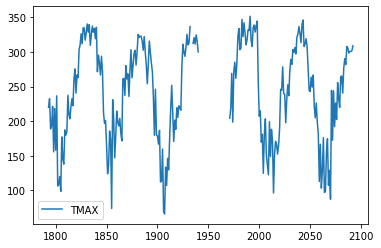

In [22]:
haha[haha['FIPS'] == 1007][['TMAX']].plot()

In [ ]:
haha 